In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os
DIR_INPUT_IMAGES='/Users/skulkarni9/Desktop/face-mask-detection/archive/images/'
DIR_INPUT_ANNOTATION='/Users/skulkarni9/Desktop/face-mask-detection/archive/annotations/'

In [2]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
imgs = list(sorted(os.listdir(DIR_INPUT_IMAGES)))

In [4]:
labels = list(sorted(os.listdir(DIR_INPUT_ANNOTATION)))

In [5]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(DIR_INPUT_IMAGES)))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(DIR_INPUT_IMAGES, file_image)
        label_path = os.path.join(DIR_INPUT_ANNOTATION, file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [7]:
class MaskDatasetTest(object):
    def __init__(self, transforms, num):
        self.transforms = transforms
        self.imgs = list(os.listdir(DIR_INPUT_IMAGES))[:num]

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(DIR_INPUT_IMAGES, file_image)
        label_path = os.path.join(DIR_INPUT_ANNOTATION, file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

dataset_test = MaskDatasetTest(data_transform, 1)
data_loader_test = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [9]:
torch.cuda.is_available()

False

# Model

In [10]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [11]:
model = get_model_instance_segmentation(3)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0]), 'image_id': tensor([0])}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]), 'image_id': tensor([1])}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]]), 'labels': tensor([1, 1, 1, 2]), 'image_id': tensor([2])}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
        [112.,  51., 120.,  68.],
        [155.,  60., 177.,  83.],
        [189.,  59., 210.,  80.],
        [235.,  57., 257.,  78.],
        [289.,  60.

# Train Model

In [13]:
num_epochs = 20
# num_epochs = 1
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        print(f'Epoch: {epoch}, Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)


Epoch: 0, Iteration: 1/214, Loss: 1.3496911525726318
Epoch: 0, Iteration: 2/214, Loss: 0.6434327363967896
Epoch: 0, Iteration: 3/214, Loss: 0.25804999470710754
Epoch: 0, Iteration: 4/214, Loss: 0.9164910912513733
Epoch: 0, Iteration: 5/214, Loss: 0.35377931594848633
Epoch: 0, Iteration: 6/214, Loss: 0.5397952198982239
Epoch: 0, Iteration: 7/214, Loss: 0.21923436224460602
Epoch: 0, Iteration: 8/214, Loss: 0.4555453062057495
Epoch: 0, Iteration: 9/214, Loss: 0.7985216975212097
Epoch: 0, Iteration: 10/214, Loss: 1.7434266805648804
Epoch: 0, Iteration: 11/214, Loss: 0.7289219498634338
Epoch: 0, Iteration: 12/214, Loss: 0.820988655090332
Epoch: 0, Iteration: 13/214, Loss: 0.15790285170078278
Epoch: 0, Iteration: 14/214, Loss: 1.7967579364776611
Epoch: 0, Iteration: 15/214, Loss: 0.3583555519580841
Epoch: 0, Iteration: 16/214, Loss: 0.23438160121440887
Epoch: 0, Iteration: 17/214, Loss: 2.1885969638824463
Epoch: 0, Iteration: 18/214, Loss: 0.03973700478672981
Epoch: 0, Iteration: 19/214, Los

Epoch: 0, Iteration: 151/214, Loss: 0.08791974186897278
Epoch: 0, Iteration: 152/214, Loss: 0.42702317237854004
Epoch: 0, Iteration: 153/214, Loss: 0.17574520409107208
Epoch: 0, Iteration: 154/214, Loss: 0.19141827523708344
Epoch: 0, Iteration: 155/214, Loss: 0.7611939907073975
Epoch: 0, Iteration: 156/214, Loss: 0.36963531374931335
Epoch: 0, Iteration: 157/214, Loss: 0.02399095892906189
Epoch: 0, Iteration: 158/214, Loss: 0.2485688477754593
Epoch: 0, Iteration: 159/214, Loss: 0.08055850118398666
Epoch: 0, Iteration: 160/214, Loss: 0.30898186564445496
Epoch: 0, Iteration: 161/214, Loss: 0.5883904695510864
Epoch: 0, Iteration: 162/214, Loss: 0.10951968282461166
Epoch: 0, Iteration: 163/214, Loss: 0.273968368768692
Epoch: 0, Iteration: 164/214, Loss: 0.1013139933347702
Epoch: 0, Iteration: 165/214, Loss: 0.8155924677848816
Epoch: 0, Iteration: 166/214, Loss: 0.015845132991671562
Epoch: 0, Iteration: 167/214, Loss: 0.1067764088511467
Epoch: 0, Iteration: 168/214, Loss: 0.12935438752174377

Epoch: 1, Iteration: 86/214, Loss: 0.30332687497138977
Epoch: 1, Iteration: 87/214, Loss: 0.5414319634437561
Epoch: 1, Iteration: 88/214, Loss: 0.006690181791782379
Epoch: 1, Iteration: 89/214, Loss: 0.11940352618694305
Epoch: 1, Iteration: 90/214, Loss: 0.08279234915971756
Epoch: 1, Iteration: 91/214, Loss: 0.14664235711097717
Epoch: 1, Iteration: 92/214, Loss: 0.34649649262428284
Epoch: 1, Iteration: 93/214, Loss: 0.49453067779541016
Epoch: 1, Iteration: 94/214, Loss: 0.2214217633008957
Epoch: 1, Iteration: 95/214, Loss: 0.6594120860099792
Epoch: 1, Iteration: 96/214, Loss: 0.09906287491321564
Epoch: 1, Iteration: 97/214, Loss: 0.3350337743759155
Epoch: 1, Iteration: 98/214, Loss: 0.7753677368164062
Epoch: 1, Iteration: 99/214, Loss: 0.18890483677387238
Epoch: 1, Iteration: 100/214, Loss: 0.4534575939178467
Epoch: 1, Iteration: 101/214, Loss: 0.25754544138908386
Epoch: 1, Iteration: 102/214, Loss: 0.011888979002833366
Epoch: 1, Iteration: 103/214, Loss: 0.710036039352417
Epoch: 1, It

Epoch: 2, Iteration: 20/214, Loss: 0.3654152750968933
Epoch: 2, Iteration: 21/214, Loss: 0.0373147577047348
Epoch: 2, Iteration: 22/214, Loss: 0.23797930777072906
Epoch: 2, Iteration: 23/214, Loss: 0.056432563811540604
Epoch: 2, Iteration: 24/214, Loss: 0.3974199891090393
Epoch: 2, Iteration: 25/214, Loss: 0.15322238206863403
Epoch: 2, Iteration: 26/214, Loss: 0.21408091485500336
Epoch: 2, Iteration: 27/214, Loss: 0.17331892251968384
Epoch: 2, Iteration: 28/214, Loss: 0.22733570635318756
Epoch: 2, Iteration: 29/214, Loss: 0.16477620601654053
Epoch: 2, Iteration: 30/214, Loss: 0.36531198024749756
Epoch: 2, Iteration: 31/214, Loss: 0.05527617409825325
Epoch: 2, Iteration: 32/214, Loss: 0.20254388451576233
Epoch: 2, Iteration: 33/214, Loss: 0.002790481550619006
Epoch: 2, Iteration: 34/214, Loss: 0.2398415356874466
Epoch: 2, Iteration: 35/214, Loss: 0.043304458260536194
Epoch: 2, Iteration: 36/214, Loss: 0.13117781281471252
Epoch: 2, Iteration: 37/214, Loss: 0.22068004310131073
Epoch: 2, I

Epoch: 2, Iteration: 169/214, Loss: 0.40291401743888855
Epoch: 2, Iteration: 170/214, Loss: 0.3408209979534149
Epoch: 2, Iteration: 171/214, Loss: 0.633654773235321
Epoch: 2, Iteration: 172/214, Loss: 0.18872295320034027
Epoch: 2, Iteration: 173/214, Loss: 0.08198939263820648
Epoch: 2, Iteration: 174/214, Loss: 0.08494964241981506
Epoch: 2, Iteration: 175/214, Loss: 0.2766443192958832
Epoch: 2, Iteration: 176/214, Loss: 0.12461501359939575
Epoch: 2, Iteration: 177/214, Loss: 0.2942200005054474
Epoch: 2, Iteration: 178/214, Loss: 0.13524267077445984
Epoch: 2, Iteration: 179/214, Loss: 0.02851901203393936
Epoch: 2, Iteration: 180/214, Loss: 0.0016759419813752174
Epoch: 2, Iteration: 181/214, Loss: 0.27288392186164856
Epoch: 2, Iteration: 182/214, Loss: 0.042948491871356964
Epoch: 2, Iteration: 183/214, Loss: 0.5263063311576843
Epoch: 2, Iteration: 184/214, Loss: 0.34570997953414917
Epoch: 2, Iteration: 185/214, Loss: 0.11360573768615723
Epoch: 2, Iteration: 186/214, Loss: 0.1330269128084

Epoch: 3, Iteration: 104/214, Loss: 0.16374631226062775
Epoch: 3, Iteration: 105/214, Loss: 0.28579282760620117
Epoch: 3, Iteration: 106/214, Loss: 0.002055500168353319
Epoch: 3, Iteration: 107/214, Loss: 0.5377839803695679
Epoch: 3, Iteration: 108/214, Loss: 0.649952232837677
Epoch: 3, Iteration: 109/214, Loss: 0.06666810810565948
Epoch: 3, Iteration: 110/214, Loss: 0.1166386678814888
Epoch: 3, Iteration: 111/214, Loss: 0.6288265585899353
Epoch: 3, Iteration: 112/214, Loss: 0.21576263010501862
Epoch: 3, Iteration: 113/214, Loss: 0.19912581145763397
Epoch: 3, Iteration: 114/214, Loss: 0.14079219102859497
Epoch: 3, Iteration: 115/214, Loss: 0.02894481271505356
Epoch: 3, Iteration: 116/214, Loss: 0.4249488115310669
Epoch: 3, Iteration: 117/214, Loss: 0.1883995532989502
Epoch: 3, Iteration: 118/214, Loss: 0.09832746535539627
Epoch: 3, Iteration: 119/214, Loss: 0.09855204075574875
Epoch: 3, Iteration: 120/214, Loss: 0.3917683959007263
Epoch: 3, Iteration: 121/214, Loss: 0.06305243819952011

Epoch: 4, Iteration: 37/214, Loss: 0.21516890823841095
Epoch: 4, Iteration: 38/214, Loss: 0.1820226013660431
Epoch: 4, Iteration: 39/214, Loss: 0.35630491375923157
Epoch: 4, Iteration: 40/214, Loss: 0.6413276195526123
Epoch: 4, Iteration: 41/214, Loss: 0.11786184459924698
Epoch: 4, Iteration: 42/214, Loss: 0.3332204818725586
Epoch: 4, Iteration: 43/214, Loss: 0.18021047115325928
Epoch: 4, Iteration: 44/214, Loss: 0.002122970065101981
Epoch: 4, Iteration: 45/214, Loss: 0.43330761790275574
Epoch: 4, Iteration: 46/214, Loss: 0.05442088842391968
Epoch: 4, Iteration: 47/214, Loss: 0.5207477807998657
Epoch: 4, Iteration: 48/214, Loss: 0.04667683318257332
Epoch: 4, Iteration: 49/214, Loss: 0.04352012276649475
Epoch: 4, Iteration: 50/214, Loss: 0.047470398247241974
Epoch: 4, Iteration: 51/214, Loss: 0.1287367045879364
Epoch: 4, Iteration: 52/214, Loss: 0.38997820019721985
Epoch: 4, Iteration: 53/214, Loss: 0.08583367615938187
Epoch: 4, Iteration: 54/214, Loss: 0.055101629346609116
Epoch: 4, It

Epoch: 4, Iteration: 185/214, Loss: 0.09423176199197769
Epoch: 4, Iteration: 186/214, Loss: 0.05595562234520912
Epoch: 4, Iteration: 187/214, Loss: 0.06543705612421036
Epoch: 4, Iteration: 188/214, Loss: 0.17853644490242004
Epoch: 4, Iteration: 189/214, Loss: 0.5458992719650269
Epoch: 4, Iteration: 190/214, Loss: 0.2549411952495575
Epoch: 4, Iteration: 191/214, Loss: 0.42417001724243164
Epoch: 4, Iteration: 192/214, Loss: 0.03581347316503525
Epoch: 4, Iteration: 193/214, Loss: 0.26116234064102173
Epoch: 4, Iteration: 194/214, Loss: 0.01573835499584675
Epoch: 4, Iteration: 195/214, Loss: 0.07702510803937912
Epoch: 4, Iteration: 196/214, Loss: 0.3934847414493561
Epoch: 4, Iteration: 197/214, Loss: 0.2589222490787506
Epoch: 4, Iteration: 198/214, Loss: 0.15129044651985168
Epoch: 4, Iteration: 199/214, Loss: 0.045432936400175095
Epoch: 4, Iteration: 200/214, Loss: 0.2782309949398041
Epoch: 4, Iteration: 201/214, Loss: 0.23727844655513763
Epoch: 4, Iteration: 202/214, Loss: 0.40294453501701

Epoch: 5, Iteration: 119/214, Loss: 0.08744177967309952
Epoch: 5, Iteration: 120/214, Loss: 0.4440840184688568
Epoch: 5, Iteration: 121/214, Loss: 0.061580825597047806
Epoch: 5, Iteration: 122/214, Loss: 0.1474674791097641
Epoch: 5, Iteration: 123/214, Loss: 0.14406947791576385
Epoch: 5, Iteration: 124/214, Loss: 0.06471075117588043
Epoch: 5, Iteration: 125/214, Loss: 0.13023139536380768
Epoch: 5, Iteration: 126/214, Loss: 0.024716518819332123
Epoch: 5, Iteration: 127/214, Loss: 0.05898034945130348
Epoch: 5, Iteration: 128/214, Loss: 0.18213921785354614
Epoch: 5, Iteration: 129/214, Loss: 0.36871102452278137
Epoch: 5, Iteration: 130/214, Loss: 0.3198757469654083
Epoch: 5, Iteration: 131/214, Loss: 0.05354177579283714
Epoch: 5, Iteration: 132/214, Loss: 0.3927883803844452
Epoch: 5, Iteration: 133/214, Loss: 0.0026699183508753777
Epoch: 5, Iteration: 134/214, Loss: 0.06525551527738571
Epoch: 5, Iteration: 135/214, Loss: 0.049629535526037216
Epoch: 5, Iteration: 136/214, Loss: 0.001385723

Epoch: 6, Iteration: 52/214, Loss: 0.3368285894393921
Epoch: 6, Iteration: 53/214, Loss: 0.09082524478435516
Epoch: 6, Iteration: 54/214, Loss: 0.04324988275766373
Epoch: 6, Iteration: 55/214, Loss: 0.21220755577087402
Epoch: 6, Iteration: 56/214, Loss: 0.042446721345186234
Epoch: 6, Iteration: 57/214, Loss: 0.05383183807134628
Epoch: 6, Iteration: 58/214, Loss: 0.043452344834804535
Epoch: 6, Iteration: 59/214, Loss: 0.26130005717277527
Epoch: 6, Iteration: 60/214, Loss: 0.005374717526137829
Epoch: 6, Iteration: 61/214, Loss: 0.21673420071601868
Epoch: 6, Iteration: 62/214, Loss: 0.04849226772785187
Epoch: 6, Iteration: 63/214, Loss: 0.004201705567538738
Epoch: 6, Iteration: 64/214, Loss: 0.0405464693903923
Epoch: 6, Iteration: 65/214, Loss: 0.3273754119873047
Epoch: 6, Iteration: 66/214, Loss: 0.432717889547348
Epoch: 6, Iteration: 67/214, Loss: 0.24438823759555817
Epoch: 6, Iteration: 68/214, Loss: 0.05489949882030487
Epoch: 6, Iteration: 69/214, Loss: 0.12280695885419846
Epoch: 6, I

Epoch: 6, Iteration: 200/214, Loss: 0.3244231939315796
Epoch: 6, Iteration: 201/214, Loss: 0.24391412734985352
Epoch: 6, Iteration: 202/214, Loss: 0.4865131378173828
Epoch: 6, Iteration: 203/214, Loss: 0.06268879026174545
Epoch: 6, Iteration: 204/214, Loss: 0.20987600088119507
Epoch: 6, Iteration: 205/214, Loss: 0.20777255296707153
Epoch: 6, Iteration: 206/214, Loss: 0.026805415749549866
Epoch: 6, Iteration: 207/214, Loss: 0.38304683566093445
Epoch: 6, Iteration: 208/214, Loss: 0.032593805342912674
Epoch: 6, Iteration: 209/214, Loss: 0.09367581456899643
Epoch: 6, Iteration: 210/214, Loss: 0.35938510298728943
Epoch: 6, Iteration: 211/214, Loss: 0.1639273315668106
Epoch: 6, Iteration: 212/214, Loss: 0.12544214725494385
Epoch: 6, Iteration: 213/214, Loss: 0.386157751083374
Epoch: 6, Iteration: 214/214, Loss: 0.06119012460112572
tensor(33.1038, grad_fn=<AddBackward0>)
Epoch: 7, Iteration: 1/214, Loss: 0.056327857077121735
Epoch: 7, Iteration: 2/214, Loss: 0.06815304607152939
Epoch: 7, Iter

Epoch: 7, Iteration: 134/214, Loss: 0.03571797534823418
Epoch: 7, Iteration: 135/214, Loss: 0.046516817063093185
Epoch: 7, Iteration: 136/214, Loss: 0.0022408473305404186
Epoch: 7, Iteration: 137/214, Loss: 0.0016012353589758277
Epoch: 7, Iteration: 138/214, Loss: 0.05416825786232948
Epoch: 7, Iteration: 139/214, Loss: 0.07949248701334
Epoch: 7, Iteration: 140/214, Loss: 0.3680148124694824
Epoch: 7, Iteration: 141/214, Loss: 0.07390189170837402
Epoch: 7, Iteration: 142/214, Loss: 0.455431193113327
Epoch: 7, Iteration: 143/214, Loss: 0.05364426225423813
Epoch: 7, Iteration: 144/214, Loss: 0.1891850382089615
Epoch: 7, Iteration: 145/214, Loss: 0.05010204389691353
Epoch: 7, Iteration: 146/214, Loss: 0.0606323778629303
Epoch: 7, Iteration: 147/214, Loss: 0.23378372192382812
Epoch: 7, Iteration: 148/214, Loss: 0.15056133270263672
Epoch: 7, Iteration: 149/214, Loss: 0.03240860626101494
Epoch: 7, Iteration: 150/214, Loss: 0.02794003114104271
Epoch: 7, Iteration: 151/214, Loss: 0.0341031625866

Epoch: 8, Iteration: 68/214, Loss: 0.06853850930929184
Epoch: 8, Iteration: 69/214, Loss: 0.10856736451387405
Epoch: 8, Iteration: 70/214, Loss: 0.08902628719806671
Epoch: 8, Iteration: 71/214, Loss: 0.37365636229515076
Epoch: 8, Iteration: 72/214, Loss: 0.32792767882347107
Epoch: 8, Iteration: 73/214, Loss: 0.13590727746486664
Epoch: 8, Iteration: 74/214, Loss: 0.10581555217504501
Epoch: 8, Iteration: 75/214, Loss: 0.2573806941509247
Epoch: 8, Iteration: 76/214, Loss: 0.033503711223602295
Epoch: 8, Iteration: 77/214, Loss: 0.07213984429836273
Epoch: 8, Iteration: 78/214, Loss: 0.10483864694833755
Epoch: 8, Iteration: 79/214, Loss: 0.12139986455440521
Epoch: 8, Iteration: 80/214, Loss: 0.08947819471359253
Epoch: 8, Iteration: 81/214, Loss: 0.09985759854316711
Epoch: 8, Iteration: 82/214, Loss: 0.0577683188021183
Epoch: 8, Iteration: 83/214, Loss: 0.024003373458981514
Epoch: 8, Iteration: 84/214, Loss: 0.0418236069381237
Epoch: 8, Iteration: 85/214, Loss: 0.1863848716020584
Epoch: 8, It

Epoch: 9, Iteration: 1/214, Loss: 0.0695347785949707
Epoch: 9, Iteration: 2/214, Loss: 0.04927363991737366
Epoch: 9, Iteration: 3/214, Loss: 0.04542018845677376
Epoch: 9, Iteration: 4/214, Loss: 0.4261389374732971
Epoch: 9, Iteration: 5/214, Loss: 0.05374331772327423
Epoch: 9, Iteration: 6/214, Loss: 0.046129707247018814
Epoch: 9, Iteration: 7/214, Loss: 0.03404052183032036
Epoch: 9, Iteration: 8/214, Loss: 0.06480257958173752
Epoch: 9, Iteration: 9/214, Loss: 0.13031083345413208
Epoch: 9, Iteration: 10/214, Loss: 0.3619624972343445
Epoch: 9, Iteration: 11/214, Loss: 0.15715010464191437
Epoch: 9, Iteration: 12/214, Loss: 0.17139309644699097
Epoch: 9, Iteration: 13/214, Loss: 0.008814271539449692
Epoch: 9, Iteration: 14/214, Loss: 0.7310939431190491
Epoch: 9, Iteration: 15/214, Loss: 0.036835286766290665
Epoch: 9, Iteration: 16/214, Loss: 0.023705322295427322
Epoch: 9, Iteration: 17/214, Loss: 0.9530271291732788
Epoch: 9, Iteration: 18/214, Loss: 0.004188066814094782
Epoch: 9, Iteration

Epoch: 9, Iteration: 150/214, Loss: 0.05647953972220421
Epoch: 9, Iteration: 151/214, Loss: 0.03533453494310379
Epoch: 9, Iteration: 152/214, Loss: 0.06698041409254074
Epoch: 9, Iteration: 153/214, Loss: 0.044780291616916656
Epoch: 9, Iteration: 154/214, Loss: 0.04557972401380539
Epoch: 9, Iteration: 155/214, Loss: 0.2587282657623291
Epoch: 9, Iteration: 156/214, Loss: 0.20683826506137848
Epoch: 9, Iteration: 157/214, Loss: 0.0013045446248725057
Epoch: 9, Iteration: 158/214, Loss: 0.055439986288547516
Epoch: 9, Iteration: 159/214, Loss: 0.028774095699191093
Epoch: 9, Iteration: 160/214, Loss: 0.10303255915641785
Epoch: 9, Iteration: 161/214, Loss: 0.25839662551879883
Epoch: 9, Iteration: 162/214, Loss: 0.02610555849969387
Epoch: 9, Iteration: 163/214, Loss: 0.1333724856376648
Epoch: 9, Iteration: 164/214, Loss: 0.02341390587389469
Epoch: 9, Iteration: 165/214, Loss: 0.2666633427143097
Epoch: 9, Iteration: 166/214, Loss: 0.0015010425122454762
Epoch: 9, Iteration: 167/214, Loss: 0.043162

Epoch: 10, Iteration: 82/214, Loss: 0.03207189962267876
Epoch: 10, Iteration: 83/214, Loss: 0.023422742262482643
Epoch: 10, Iteration: 84/214, Loss: 0.03544631227850914
Epoch: 10, Iteration: 85/214, Loss: 0.23332880437374115
Epoch: 10, Iteration: 86/214, Loss: 0.10271555185317993
Epoch: 10, Iteration: 87/214, Loss: 0.13981463015079498
Epoch: 10, Iteration: 88/214, Loss: 0.0008654613047838211
Epoch: 10, Iteration: 89/214, Loss: 0.032965920865535736
Epoch: 10, Iteration: 90/214, Loss: 0.0188718494027853
Epoch: 10, Iteration: 91/214, Loss: 0.031277500092983246
Epoch: 10, Iteration: 92/214, Loss: 0.13861043751239777
Epoch: 10, Iteration: 93/214, Loss: 0.27244213223457336
Epoch: 10, Iteration: 94/214, Loss: 0.09608578681945801
Epoch: 10, Iteration: 95/214, Loss: 0.21289625763893127
Epoch: 10, Iteration: 96/214, Loss: 0.027201442047953606
Epoch: 10, Iteration: 97/214, Loss: 0.09047101438045502
Epoch: 10, Iteration: 98/214, Loss: 0.21787138283252716
Epoch: 10, Iteration: 99/214, Loss: 0.04411

Epoch: 11, Iteration: 12/214, Loss: 0.161769837141037
Epoch: 11, Iteration: 13/214, Loss: 0.0013547125272452831
Epoch: 11, Iteration: 14/214, Loss: 0.4743257164955139
Epoch: 11, Iteration: 15/214, Loss: 0.04244200885295868
Epoch: 11, Iteration: 16/214, Loss: 0.04490182176232338
Epoch: 11, Iteration: 17/214, Loss: 1.3096433877944946
Epoch: 11, Iteration: 18/214, Loss: 0.0005578231648541987
Epoch: 11, Iteration: 19/214, Loss: 0.0037732429336756468
Epoch: 11, Iteration: 20/214, Loss: 0.2284310758113861
Epoch: 11, Iteration: 21/214, Loss: 0.04586418345570564
Epoch: 11, Iteration: 22/214, Loss: 0.12556961178779602
Epoch: 11, Iteration: 23/214, Loss: 0.05062631517648697
Epoch: 11, Iteration: 24/214, Loss: 0.28057169914245605
Epoch: 11, Iteration: 25/214, Loss: 0.05647299066185951
Epoch: 11, Iteration: 26/214, Loss: 0.11350144445896149
Epoch: 11, Iteration: 27/214, Loss: 0.06730596721172333
Epoch: 11, Iteration: 28/214, Loss: 0.16834504902362823
Epoch: 11, Iteration: 29/214, Loss: 0.068977542

Epoch: 11, Iteration: 157/214, Loss: 0.0007152208127081394
Epoch: 11, Iteration: 158/214, Loss: 0.07380534708499908
Epoch: 11, Iteration: 159/214, Loss: 0.033072274178266525
Epoch: 11, Iteration: 160/214, Loss: 0.12359066307544708
Epoch: 11, Iteration: 161/214, Loss: 0.2265380471944809
Epoch: 11, Iteration: 162/214, Loss: 0.02825595997273922
Epoch: 11, Iteration: 163/214, Loss: 0.10581497102975845
Epoch: 11, Iteration: 164/214, Loss: 0.04707632213830948
Epoch: 11, Iteration: 165/214, Loss: 0.2900884449481964
Epoch: 11, Iteration: 166/214, Loss: 0.0005519936676137149
Epoch: 11, Iteration: 167/214, Loss: 0.0383792407810688
Epoch: 11, Iteration: 168/214, Loss: 0.02454317919909954
Epoch: 11, Iteration: 169/214, Loss: 0.14065654575824738
Epoch: 11, Iteration: 170/214, Loss: 0.16138072311878204
Epoch: 11, Iteration: 171/214, Loss: 0.18545475602149963
Epoch: 11, Iteration: 172/214, Loss: 0.06130274385213852
Epoch: 11, Iteration: 173/214, Loss: 0.03091469220817089
Epoch: 11, Iteration: 174/214

Epoch: 12, Iteration: 88/214, Loss: 0.004660109058022499
Epoch: 12, Iteration: 89/214, Loss: 0.034325916320085526
Epoch: 12, Iteration: 90/214, Loss: 0.039674676954746246
Epoch: 12, Iteration: 91/214, Loss: 0.054339077323675156
Epoch: 12, Iteration: 92/214, Loss: 0.16666105389595032
Epoch: 12, Iteration: 93/214, Loss: 0.2787579298019409
Epoch: 12, Iteration: 94/214, Loss: 0.06731747090816498
Epoch: 12, Iteration: 95/214, Loss: 0.20926223695278168
Epoch: 12, Iteration: 96/214, Loss: 0.038330040872097015
Epoch: 12, Iteration: 97/214, Loss: 0.07904887199401855
Epoch: 12, Iteration: 98/214, Loss: 0.2760012149810791
Epoch: 12, Iteration: 99/214, Loss: 0.055618248879909515
Epoch: 12, Iteration: 100/214, Loss: 0.17766043543815613
Epoch: 12, Iteration: 101/214, Loss: 0.20490239560604095
Epoch: 12, Iteration: 102/214, Loss: 0.0013840236933901906
Epoch: 12, Iteration: 103/214, Loss: 0.24660000205039978
Epoch: 12, Iteration: 104/214, Loss: 0.09166601300239563
Epoch: 12, Iteration: 105/214, Loss: 

Epoch: 13, Iteration: 18/214, Loss: 0.0001663998991716653
Epoch: 13, Iteration: 19/214, Loss: 0.0006030487129464746
Epoch: 13, Iteration: 20/214, Loss: 0.18867355585098267
Epoch: 13, Iteration: 21/214, Loss: 0.02561953105032444
Epoch: 13, Iteration: 22/214, Loss: 0.08536269515752792
Epoch: 13, Iteration: 23/214, Loss: 0.014919404871761799
Epoch: 13, Iteration: 24/214, Loss: 0.13616029918193817
Epoch: 13, Iteration: 25/214, Loss: 0.05273839458823204
Epoch: 13, Iteration: 26/214, Loss: 0.08164232224225998
Epoch: 13, Iteration: 27/214, Loss: 0.08489485830068588
Epoch: 13, Iteration: 28/214, Loss: 0.10070289671421051
Epoch: 13, Iteration: 29/214, Loss: 0.030030854046344757
Epoch: 13, Iteration: 30/214, Loss: 0.17358316481113434
Epoch: 13, Iteration: 31/214, Loss: 0.030723201110959053
Epoch: 13, Iteration: 32/214, Loss: 0.10484067350625992
Epoch: 13, Iteration: 33/214, Loss: 0.002525331685319543
Epoch: 13, Iteration: 34/214, Loss: 0.03905602544546127
Epoch: 13, Iteration: 35/214, Loss: 0.03

Epoch: 13, Iteration: 163/214, Loss: 0.12782226502895355
Epoch: 13, Iteration: 164/214, Loss: 0.030149012804031372
Epoch: 13, Iteration: 165/214, Loss: 0.36642417311668396
Epoch: 13, Iteration: 166/214, Loss: 0.0008872488979250193
Epoch: 13, Iteration: 167/214, Loss: 0.047190453857183456
Epoch: 13, Iteration: 168/214, Loss: 0.02379431203007698
Epoch: 13, Iteration: 169/214, Loss: 0.15689627826213837
Epoch: 13, Iteration: 170/214, Loss: 0.2653455138206482
Epoch: 13, Iteration: 171/214, Loss: 0.2994365692138672
Epoch: 13, Iteration: 172/214, Loss: 0.08314117044210434
Epoch: 13, Iteration: 173/214, Loss: 0.03573320806026459
Epoch: 13, Iteration: 174/214, Loss: 0.01772512122988701
Epoch: 13, Iteration: 175/214, Loss: 0.19877924025058746
Epoch: 13, Iteration: 176/214, Loss: 0.1027543842792511
Epoch: 13, Iteration: 177/214, Loss: 0.23870936036109924
Epoch: 13, Iteration: 178/214, Loss: 0.10571067035198212
Epoch: 13, Iteration: 179/214, Loss: 0.014129509218037128
Epoch: 13, Iteration: 180/214

Epoch: 14, Iteration: 94/214, Loss: 0.06967882812023163
Epoch: 14, Iteration: 95/214, Loss: 0.17861075699329376
Epoch: 14, Iteration: 96/214, Loss: 0.02776676043868065
Epoch: 14, Iteration: 97/214, Loss: 0.06975496560335159
Epoch: 14, Iteration: 98/214, Loss: 0.1609506607055664
Epoch: 14, Iteration: 99/214, Loss: 0.05018536001443863
Epoch: 14, Iteration: 100/214, Loss: 0.07763965427875519
Epoch: 14, Iteration: 101/214, Loss: 0.0862392708659172
Epoch: 14, Iteration: 102/214, Loss: 0.0006878688000142574
Epoch: 14, Iteration: 103/214, Loss: 0.16935794055461884
Epoch: 14, Iteration: 104/214, Loss: 0.05707878991961479
Epoch: 14, Iteration: 105/214, Loss: 0.09961329400539398
Epoch: 14, Iteration: 106/214, Loss: 0.0016883115749806166
Epoch: 14, Iteration: 107/214, Loss: 0.2268403172492981
Epoch: 14, Iteration: 108/214, Loss: 0.2764628529548645
Epoch: 14, Iteration: 109/214, Loss: 0.035996634513139725
Epoch: 14, Iteration: 110/214, Loss: 0.05472664162516594
Epoch: 14, Iteration: 111/214, Loss:

Epoch: 15, Iteration: 24/214, Loss: 0.2549591660499573
Epoch: 15, Iteration: 25/214, Loss: 0.0628785565495491
Epoch: 15, Iteration: 26/214, Loss: 0.14328214526176453
Epoch: 15, Iteration: 27/214, Loss: 0.04668310657143593
Epoch: 15, Iteration: 28/214, Loss: 0.12837335467338562
Epoch: 15, Iteration: 29/214, Loss: 0.015584349632263184
Epoch: 15, Iteration: 30/214, Loss: 0.1694738268852234
Epoch: 15, Iteration: 31/214, Loss: 0.03574857488274574
Epoch: 15, Iteration: 32/214, Loss: 0.0902203768491745
Epoch: 15, Iteration: 33/214, Loss: 0.0010195088107138872
Epoch: 15, Iteration: 34/214, Loss: 0.038219667971134186
Epoch: 15, Iteration: 35/214, Loss: 0.026950586587190628
Epoch: 15, Iteration: 36/214, Loss: 0.07525195181369781
Epoch: 15, Iteration: 37/214, Loss: 0.12913896143436432
Epoch: 15, Iteration: 38/214, Loss: 0.12529510259628296
Epoch: 15, Iteration: 39/214, Loss: 0.24647963047027588
Epoch: 15, Iteration: 40/214, Loss: 0.24856281280517578
Epoch: 15, Iteration: 41/214, Loss: 0.049891162

Epoch: 15, Iteration: 169/214, Loss: 0.19029854238033295
Epoch: 15, Iteration: 170/214, Loss: 0.17111872136592865
Epoch: 15, Iteration: 171/214, Loss: 0.16693902015686035
Epoch: 15, Iteration: 172/214, Loss: 0.05022089183330536
Epoch: 15, Iteration: 173/214, Loss: 0.027326375246047974
Epoch: 15, Iteration: 174/214, Loss: 0.017182936891913414
Epoch: 15, Iteration: 175/214, Loss: 0.17367634177207947
Epoch: 15, Iteration: 176/214, Loss: 0.07352717965841293
Epoch: 15, Iteration: 177/214, Loss: 0.1351713091135025
Epoch: 15, Iteration: 178/214, Loss: 0.057324133813381195
Epoch: 15, Iteration: 179/214, Loss: 0.00907459668815136
Epoch: 15, Iteration: 180/214, Loss: 0.00036393097252584994
Epoch: 15, Iteration: 181/214, Loss: 0.09020837396383286
Epoch: 15, Iteration: 182/214, Loss: 0.019675854593515396
Epoch: 15, Iteration: 183/214, Loss: 0.2109074592590332
Epoch: 15, Iteration: 184/214, Loss: 0.15391044318675995
Epoch: 15, Iteration: 185/214, Loss: 0.06430650502443314
Epoch: 15, Iteration: 186/

Epoch: 16, Iteration: 100/214, Loss: 0.0820976048707962
Epoch: 16, Iteration: 101/214, Loss: 0.048362307250499725
Epoch: 16, Iteration: 102/214, Loss: 0.0017566584283486009
Epoch: 16, Iteration: 103/214, Loss: 0.15983422100543976
Epoch: 16, Iteration: 104/214, Loss: 0.04221644625067711
Epoch: 16, Iteration: 105/214, Loss: 0.06799709796905518
Epoch: 16, Iteration: 106/214, Loss: 0.0010281424038112164
Epoch: 16, Iteration: 107/214, Loss: 0.22562438249588013
Epoch: 16, Iteration: 108/214, Loss: 0.2817763686180115
Epoch: 16, Iteration: 109/214, Loss: 0.034272201359272
Epoch: 16, Iteration: 110/214, Loss: 0.04649261012673378
Epoch: 16, Iteration: 111/214, Loss: 0.18465937674045563
Epoch: 16, Iteration: 112/214, Loss: 0.09360459446907043
Epoch: 16, Iteration: 113/214, Loss: 0.10672083497047424
Epoch: 16, Iteration: 114/214, Loss: 0.09075522422790527
Epoch: 16, Iteration: 115/214, Loss: 0.012424880638718605
Epoch: 16, Iteration: 116/214, Loss: 0.23378269374370575
Epoch: 16, Iteration: 117/214

Epoch: 17, Iteration: 30/214, Loss: 0.18868492543697357
Epoch: 17, Iteration: 31/214, Loss: 0.01705349050462246
Epoch: 17, Iteration: 32/214, Loss: 0.12268766760826111
Epoch: 17, Iteration: 33/214, Loss: 0.0009123027557507157
Epoch: 17, Iteration: 34/214, Loss: 0.056672412902116776
Epoch: 17, Iteration: 35/214, Loss: 0.030164986848831177
Epoch: 17, Iteration: 36/214, Loss: 0.05897603929042816
Epoch: 17, Iteration: 37/214, Loss: 0.13182111084461212
Epoch: 17, Iteration: 38/214, Loss: 0.10274797677993774
Epoch: 17, Iteration: 39/214, Loss: 0.20138317346572876
Epoch: 17, Iteration: 40/214, Loss: 0.35457295179367065
Epoch: 17, Iteration: 41/214, Loss: 0.0585818774998188
Epoch: 17, Iteration: 42/214, Loss: 0.19049783051013947
Epoch: 17, Iteration: 43/214, Loss: 0.09291674941778183
Epoch: 17, Iteration: 44/214, Loss: 0.0006430803914554417
Epoch: 17, Iteration: 45/214, Loss: 0.24982909858226776
Epoch: 17, Iteration: 46/214, Loss: 0.02405264787375927
Epoch: 17, Iteration: 47/214, Loss: 0.23369

Epoch: 17, Iteration: 175/214, Loss: 0.14992912113666534
Epoch: 17, Iteration: 176/214, Loss: 0.06456263363361359
Epoch: 17, Iteration: 177/214, Loss: 0.16517451405525208
Epoch: 17, Iteration: 178/214, Loss: 0.05667621269822121
Epoch: 17, Iteration: 179/214, Loss: 0.012666764669120312
Epoch: 17, Iteration: 180/214, Loss: 0.0003472915559541434
Epoch: 17, Iteration: 181/214, Loss: 0.10779228806495667
Epoch: 17, Iteration: 182/214, Loss: 0.0219708401709795
Epoch: 17, Iteration: 183/214, Loss: 0.22135592997074127
Epoch: 17, Iteration: 184/214, Loss: 0.16441425681114197
Epoch: 17, Iteration: 185/214, Loss: 0.06861622631549835
Epoch: 17, Iteration: 186/214, Loss: 0.05591489374637604
Epoch: 17, Iteration: 187/214, Loss: 0.046251751482486725
Epoch: 17, Iteration: 188/214, Loss: 0.03713933005928993
Epoch: 17, Iteration: 189/214, Loss: 0.31299924850463867
Epoch: 17, Iteration: 190/214, Loss: 0.08144831657409668
Epoch: 17, Iteration: 191/214, Loss: 0.13742054998874664
Epoch: 17, Iteration: 192/21

Epoch: 18, Iteration: 106/214, Loss: 0.0005738560575991869
Epoch: 18, Iteration: 107/214, Loss: 0.28773900866508484
Epoch: 18, Iteration: 108/214, Loss: 0.2761951684951782
Epoch: 18, Iteration: 109/214, Loss: 0.02887096256017685
Epoch: 18, Iteration: 110/214, Loss: 0.02717036008834839
Epoch: 18, Iteration: 111/214, Loss: 0.14089199900627136
Epoch: 18, Iteration: 112/214, Loss: 0.057259682565927505
Epoch: 18, Iteration: 113/214, Loss: 0.10165472328662872
Epoch: 18, Iteration: 114/214, Loss: 0.08581815659999847
Epoch: 18, Iteration: 115/214, Loss: 0.021369056776165962
Epoch: 18, Iteration: 116/214, Loss: 0.30723872780799866
Epoch: 18, Iteration: 117/214, Loss: 0.16359616816043854
Epoch: 18, Iteration: 118/214, Loss: 0.02403845451772213
Epoch: 18, Iteration: 119/214, Loss: 0.020012296736240387
Epoch: 18, Iteration: 120/214, Loss: 0.12125134468078613
Epoch: 18, Iteration: 121/214, Loss: 0.016706066206097603
Epoch: 18, Iteration: 122/214, Loss: 0.0344073660671711
Epoch: 18, Iteration: 123/2

Epoch: 19, Iteration: 36/214, Loss: 0.09890547394752502
Epoch: 19, Iteration: 37/214, Loss: 0.13586248457431793
Epoch: 19, Iteration: 38/214, Loss: 0.11583149433135986
Epoch: 19, Iteration: 39/214, Loss: 0.21641400456428528
Epoch: 19, Iteration: 40/214, Loss: 0.22787077724933624
Epoch: 19, Iteration: 41/214, Loss: 0.04240576922893524
Epoch: 19, Iteration: 42/214, Loss: 0.16618391871452332
Epoch: 19, Iteration: 43/214, Loss: 0.08973326534032822
Epoch: 19, Iteration: 44/214, Loss: 0.0003996190498583019
Epoch: 19, Iteration: 45/214, Loss: 0.2576598525047302
Epoch: 19, Iteration: 46/214, Loss: 0.03975715488195419
Epoch: 19, Iteration: 47/214, Loss: 0.27918192744255066
Epoch: 19, Iteration: 48/214, Loss: 0.03564561530947685
Epoch: 19, Iteration: 49/214, Loss: 0.030263788998126984
Epoch: 19, Iteration: 50/214, Loss: 0.04316553473472595
Epoch: 19, Iteration: 51/214, Loss: 0.13250477612018585
Epoch: 19, Iteration: 52/214, Loss: 0.2529655992984772
Epoch: 19, Iteration: 53/214, Loss: 0.057188481

Epoch: 19, Iteration: 181/214, Loss: 0.14482730627059937
Epoch: 19, Iteration: 182/214, Loss: 0.04101790860295296
Epoch: 19, Iteration: 183/214, Loss: 0.27639028429985046
Epoch: 19, Iteration: 184/214, Loss: 0.2242240458726883
Epoch: 19, Iteration: 185/214, Loss: 0.07495326548814774
Epoch: 19, Iteration: 186/214, Loss: 0.05775134265422821
Epoch: 19, Iteration: 187/214, Loss: 0.05324540287256241
Epoch: 19, Iteration: 188/214, Loss: 0.03153657913208008
Epoch: 19, Iteration: 189/214, Loss: 0.3746272325515747
Epoch: 19, Iteration: 190/214, Loss: 0.07926934957504272
Epoch: 19, Iteration: 191/214, Loss: 0.13463810086250305
Epoch: 19, Iteration: 192/214, Loss: 0.07200072705745697
Epoch: 19, Iteration: 193/214, Loss: 0.22616319358348846
Epoch: 19, Iteration: 194/214, Loss: 0.007899684831500053
Epoch: 19, Iteration: 195/214, Loss: 0.11339470744132996
Epoch: 19, Iteration: 196/214, Loss: 0.32253459095954895
Epoch: 19, Iteration: 197/214, Loss: 0.3660806715488434
Epoch: 19, Iteration: 198/214, Lo

In [14]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [15]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[184.1106, 100.7440, 222.7175, 143.4197]], grad_fn=<StackBackward>),
  'labels': tensor([1]),
  'scores': tensor([0.9970], grad_fn=<IndexBackward>)},
 {'boxes': tensor([[319.6333,  34.1888, 351.3741,  69.9350],
          [ 20.3452,  73.2134,  41.5051,  92.7356],
          [224.7036,  37.6873, 258.1092,  74.3038],
          [144.6570,  77.3042, 171.3346, 112.1498],
          [193.7168,  65.6196, 214.5381,  92.6266],
          [297.7188,  59.2848, 312.0234,  80.1115],
          [ 81.7952,  56.5237, 110.8098,  89.0238],
          [367.1626,  72.6239, 386.8132,  93.9132]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 2, 1]),
  'scores': tensor([0.9930, 0.9923, 0.9920, 0.9847, 0.9821, 0.9513, 0.3484, 0.0625],
         grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 71.8559,  43.8389,  98.3565,  69.2619],
          [154.0686,  49.5894, 174.6328,  73.6572],
          [331.5781,  32.6948, 370.4597,  65.2881],
          [238.7788,  34.6489, 257.9618,  65.40

# Function to plot image

In [16]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


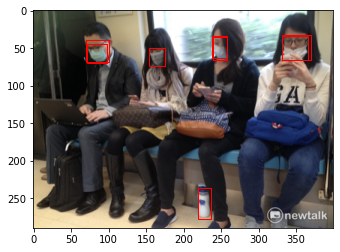

Target


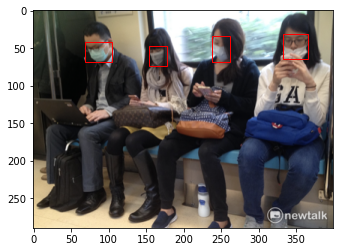

In [17]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [18]:
torch.save(model.state_dict(),'fasterrcnn.pt')

In [19]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [20]:
model2.load_state_dict(torch.load('fasterrcnn.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

# Load Model

In [21]:
pred2 = model2(imgs)

Predict with loaded model


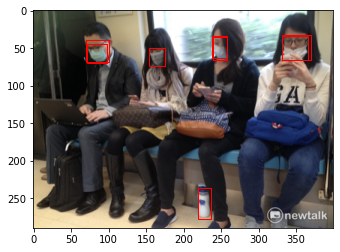

Target


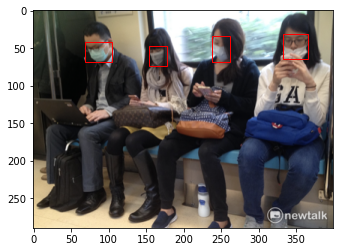

In [22]:
print("Predict with loaded model")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])